In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms

from datetime import datetime

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC

In [2]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [3]:
# Função para estratificar o dataset em k folds

def stratify_dataset(dataset, k):
    # Define qual será o dataset
    if dataset == 'dados_normalizados_aumentados_minmax':
        dataset_file = pd.read_csv("../Database/df_database_dados_normalizados_aumentados_minmax.csv")
    
    if dataset == 'dados_normalizados_aumentados_minmax_morfologicos':
        dataset_file = pd.read_csv("../Database/df_database_dados_normalizados_aumentados_minmax_morfologicos.csv")
    
    # Separa a coluna target das características
    dataset_features = dataset_file.drop('target', axis=1)
    y = dataset_file.loc[:, 'target']

    # Transformando para numpy
    #dataset_features = dataset_features.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
    X = dataset_features.to_numpy()
    
    cv = StratifiedKFold(n_splits = k, shuffle = True, random_state = 1)
    
    return dataset_file, X, y, cv

In [4]:
#dataset = 'dados_normalizados_aumentados_minmax'
dataset = 'dados_normalizados_aumentados_minmax_morfologicos'
k = 10

dataset_file, X, y, cv = stratify_dataset(dataset, k)

In [5]:
# Possíveis validações para valores nulos/ausentes ou infinitos

#print(np.count_nonzero(np.isnan(X)))     # True wherever nan
#print(np.count_nonzero(np.isposinf(X)))  # True wherever pos-inf
#print(np.count_nonzero(np.isneginf(X)))  # True wherever neg-inf
#print(np.count_nonzero(np.isinf(X)))     # True wherever pos-inf or neg-inf
#print(np.count_nonzero(~np.isfinite(X))) # True wherever pos-inf or neg-inf or nan

In [6]:
# Lista de parâmetros de treinamento e de teste para cada modelo considerado 

models_parameters = {
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9,1e-8,1e-7,1e-6,1e-5,0.0001,0.001,0.01,0.1,0.2]
        }
    },  
    'BernoulliNB':{
        'model': BernoulliNB(),
        'params': {
            'alpha':[0.0,0.001,0.01,0.1,0.2,0.5,1,1.5,10,20],
            'binarize':[0.0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
        }
    },
    'MLPClassifier': {
        'model': MLPClassifier(),
        'params': {
            'max_iter': [30, 50, 60, 90, 100, 120, 150, 180, 200, 210, 240, 250, 270, 300],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'learning_rate_init': [0.001, 0.01, 0.05, 0.1]
        }
    },
    'RandomForestClassifier': {
         'model': RandomForestClassifier(),
         'params': {
             'n_estimators': [10,100,250,500,750,1000],
             'criterion': ['gini', 'entropy'],
             'max_features': ['sqrt','log2',None],
             'n_jobs': [-1],
             'ccp_alpha': [0.0,0.02,0.04,0.08,0.16,0.32,0.64,1.28]
         }
    },
    'SVC':{
        'model': SVC(),
        'params': {
            'C': [0.001,0.01,0.1,0.5,1.0,1.5,5,10,20],
            'kernel': ['linear','poly','rbf','sigmoid'],
            'gamma': ['auto','scale',0.001,0.01,0.1],
            'probability': [True]
        }
    }
}

In [7]:
# Lista de métricas para rankeamento nos testes

scoring = {
    #'roc_auc_ovr_scorer': make_scorer(roc_auc_score, average='macro', needs_proba = True, multi_class='ovr'),
    'roc_auc_ovo_scorer': make_scorer(roc_auc_score, average='macro', needs_proba = True, multi_class='ovo'),
    'precision_scorer': make_scorer(precision_score, average='macro'),
    'recall_scorer': make_scorer(recall_score, average='macro')
}

>>>>>>>>>> Processing model GaussianNB.
Confusion matrix

     SAN  CMD  CMH
SAN  191    5    4
CMD   99   94    7
CMH  114   24   62




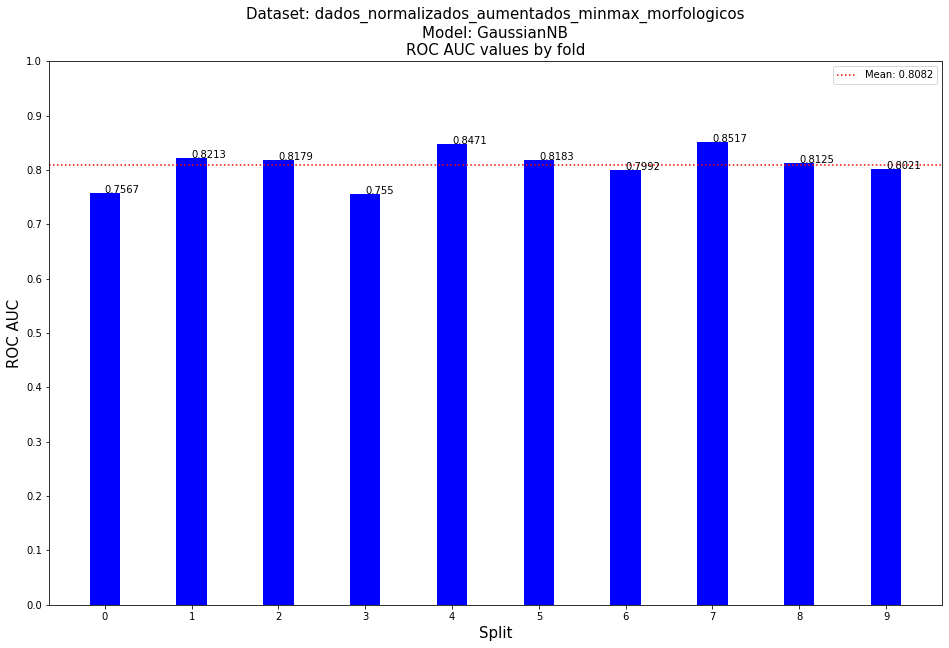

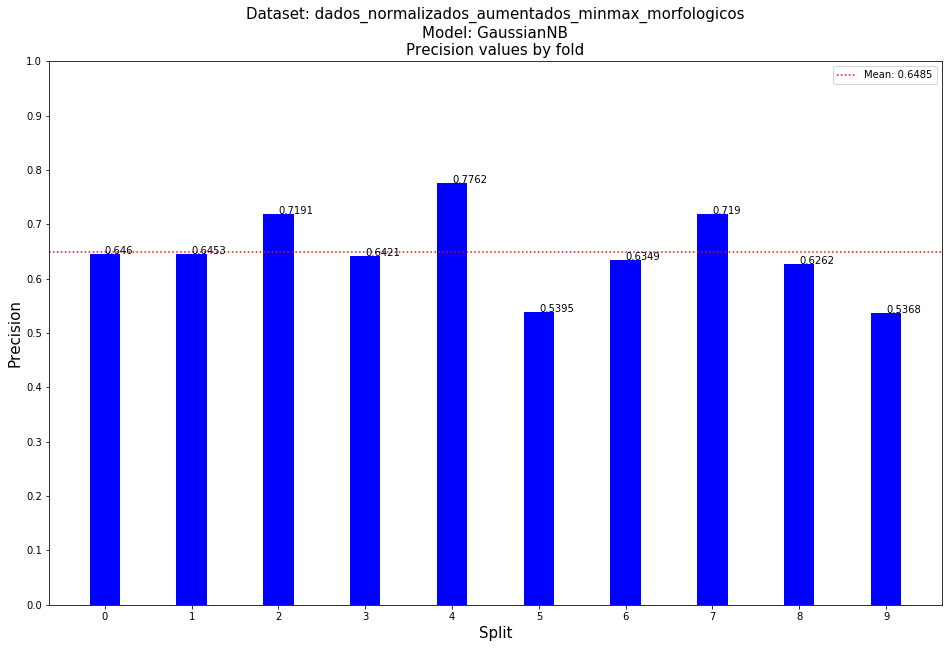

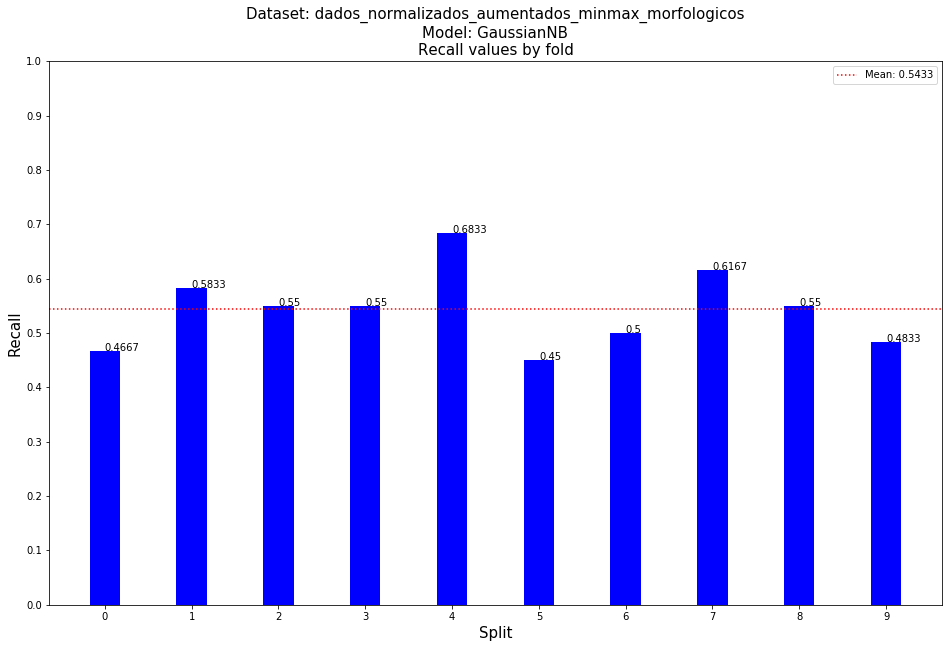

>>>>>>>>>> Processing model BernoulliNB.
Confusion matrix

     SAN  CMD  CMH
SAN   96   98    6
CMD   29  156   15
CMH   33   29  138




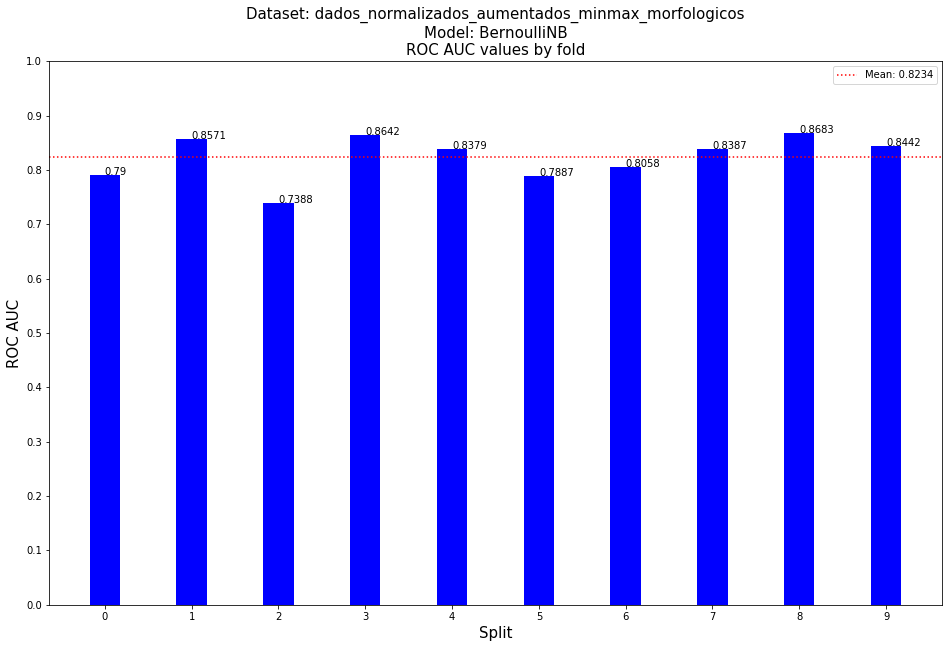

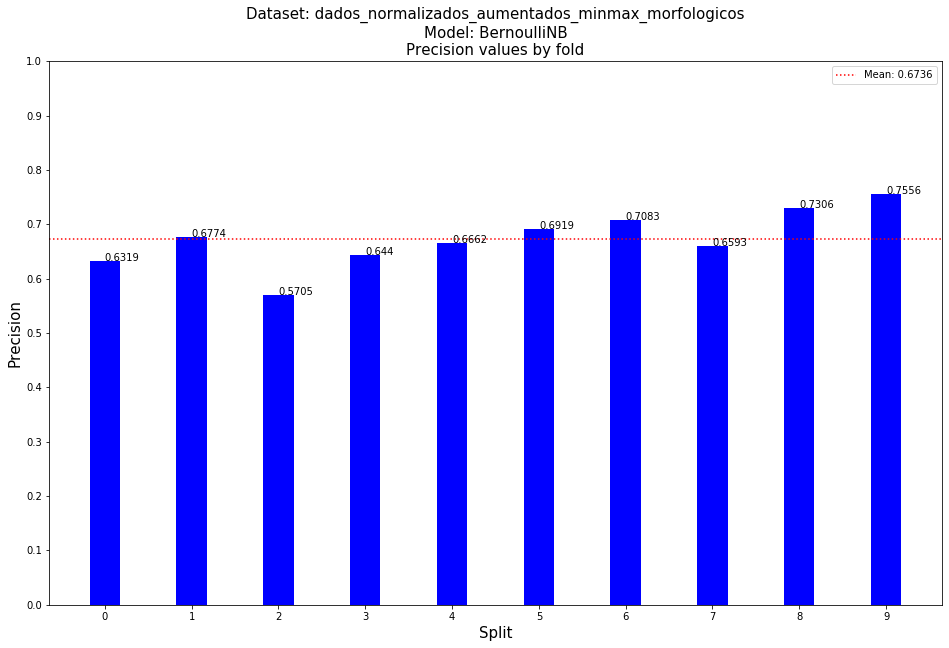

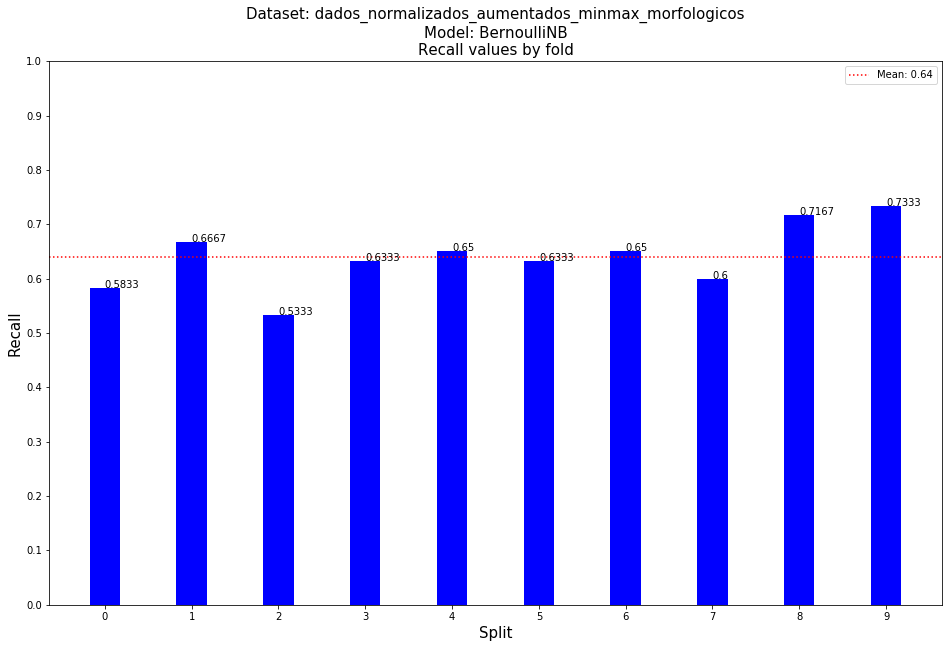

>>>>>>>>>> Processing model MLPClassifier.


/home/vagner/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Confusion matrix

     SAN  CMD  CMH
SAN  184   13    3
CMD   23  160   17
CMH   14   13  173




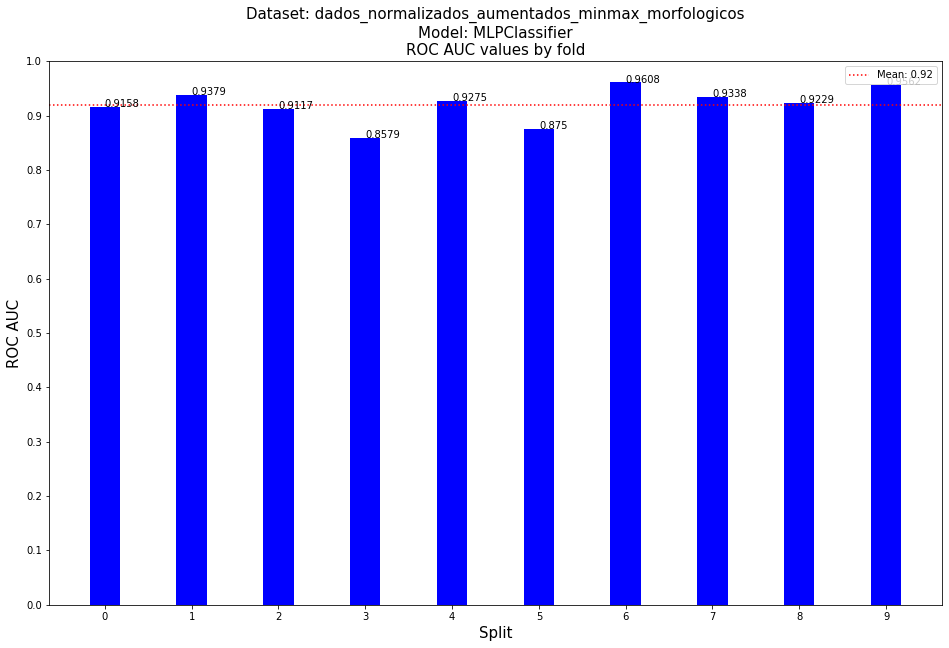

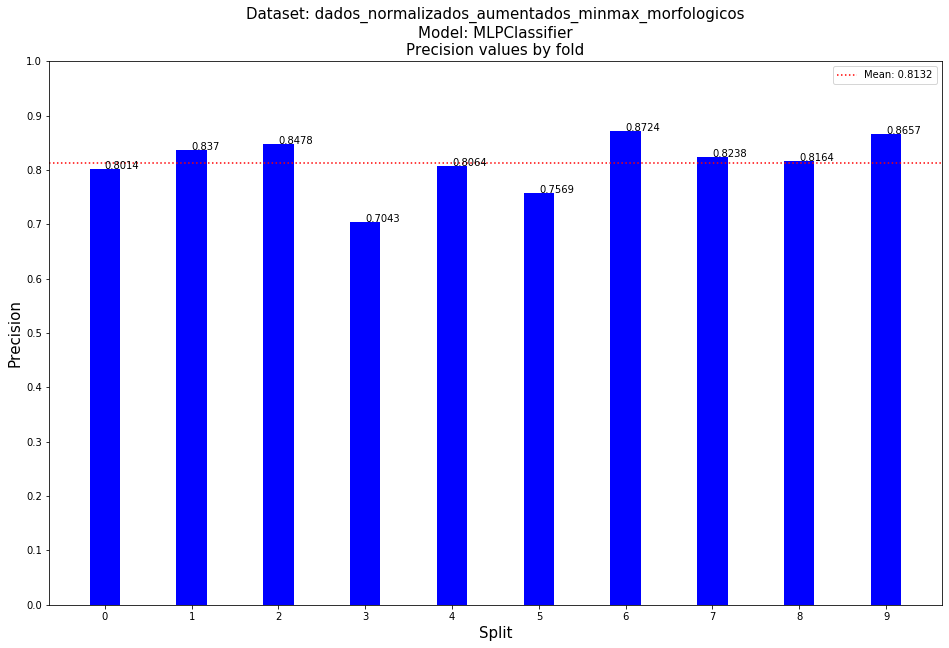

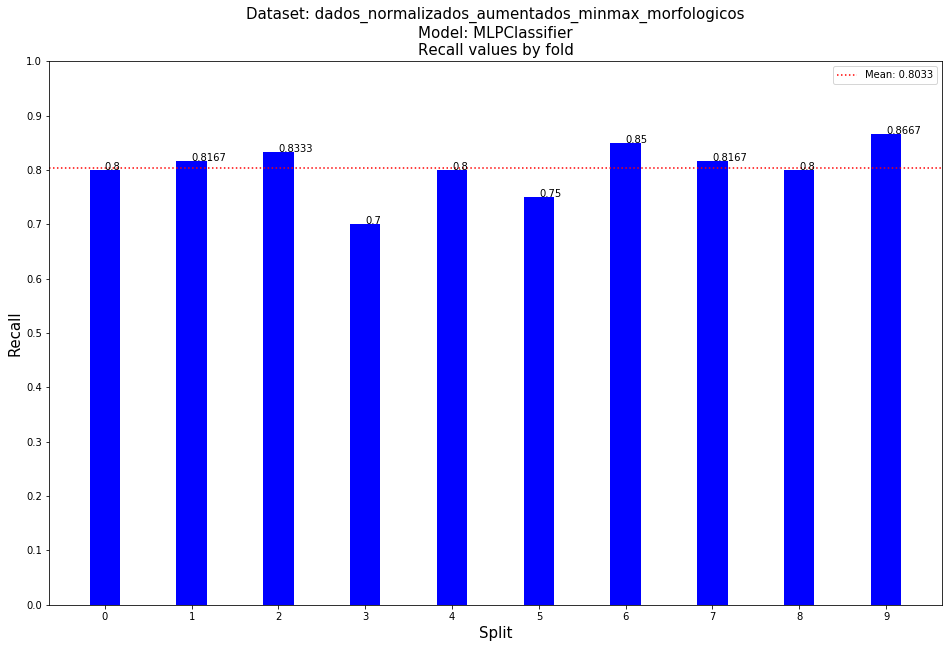

>>>>>>>>>> Processing model RandomForestClassifier.
Confusion matrix

     SAN  CMD  CMH
SAN  200    0    0
CMD    0  200    0
CMH    0    0  200




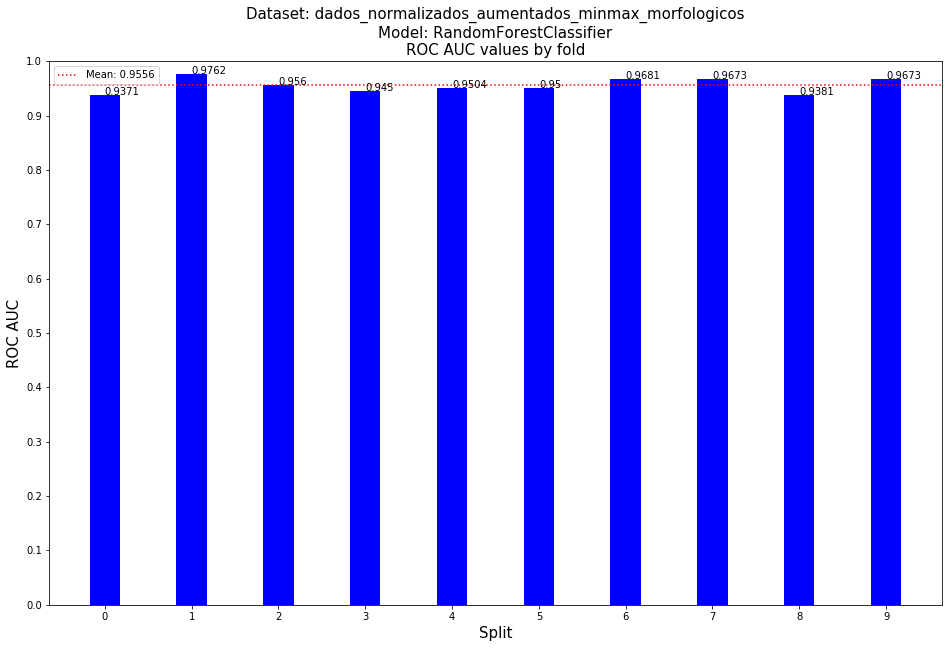

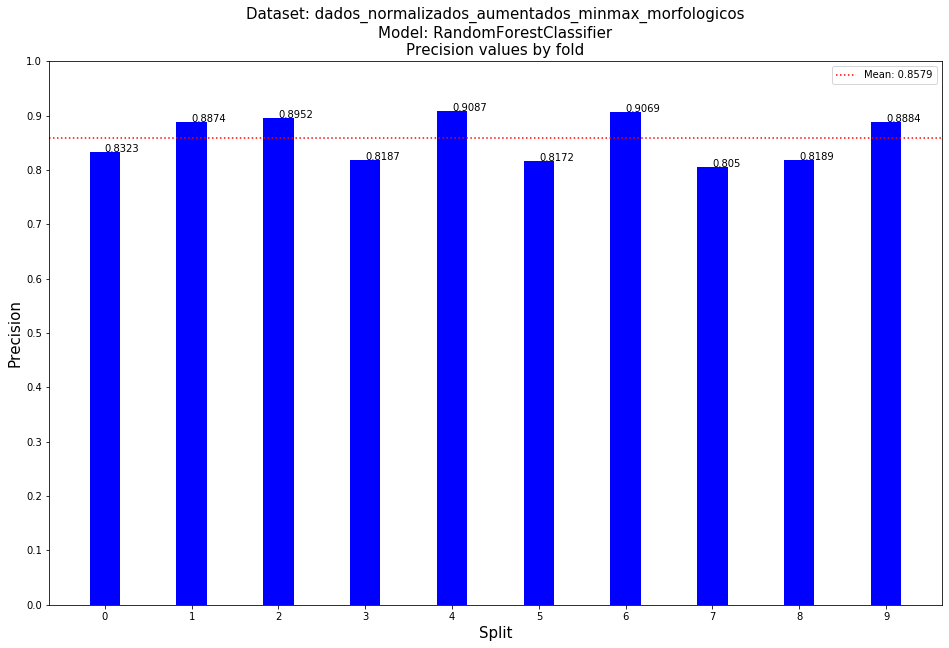

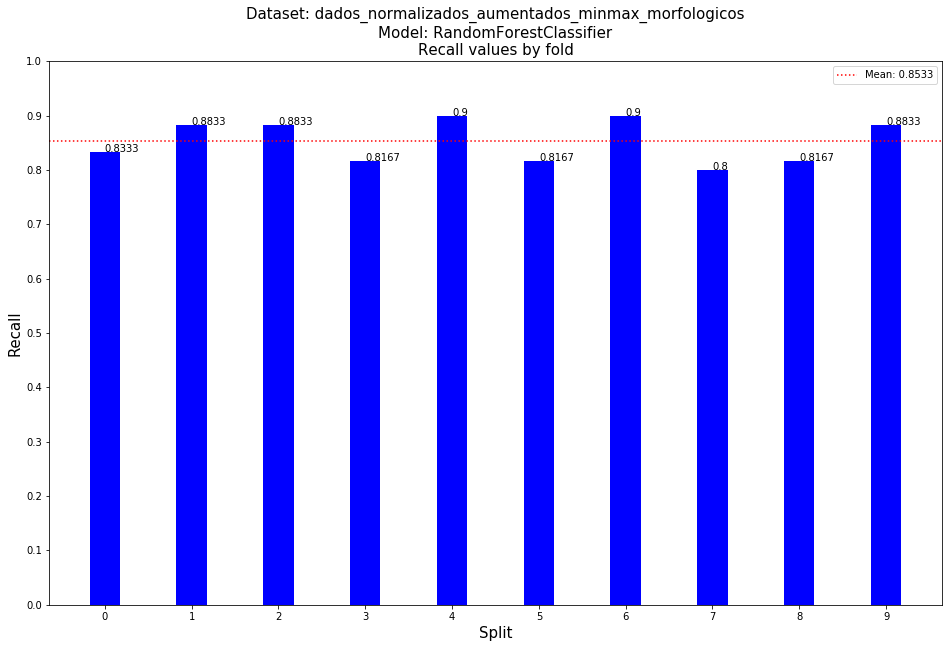

>>>>>>>>>> Processing model LinearSVC.


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [8]:
# Processamento principal

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")

# 
df_best_results = None
best_results = []

#print(X.dtype)
#print(Y.dtype)

for model_name, model_parameters in models_parameters.items():
    print(f'>>>>>>>>>> Processing model {model_name}.')
    classifier = GridSearchCV(model_parameters['model'], model_parameters['params'], cv=cv, scoring=scoring, refit='roc_auc_ovo_scorer', n_jobs=-1)
    classifier.fit(X, y)
    y_pred = classifier.predict(X)
    
    # Gera dataframe de todos os resultados obtidos para cada combinação de parâmetros 
    results = pd.DataFrame(classifier.cv_results_)
    
    #print('Results\n')
    #print(results)
    #print('\n')
    
    # Seleciona o melhor resultado (combinação de parâmetros) com base no scorer 'roc_auc_ovr_scorer'
    
    results = results.sort_values(by=['rank_test_roc_auc_ovo_scorer'])
    
    best_result = results.head(1)
    
    #print('Best result\n')
    #print(best_result)
    #print('\n')
    
    # Guarda as médias das métricas para o melhor resultado
    
    #mean_test_roc_auc_ovr_scorer = best_result['mean_test_roc_auc_ovr_scorer']
    mean_test_roc_auc_ovo_scorer = best_result['mean_test_roc_auc_ovo_scorer']
    mean_test_precision_scorer = best_result['mean_test_precision_scorer']
    mean_test_recall_scorer = best_result['mean_test_recall_scorer']
    
    # CALCULA O ÍNDICE DE CONFIANÇA DO MELHOR RESULTADO PARA CADA MÉTRICA
    #IC_ROC_OVR=[]
    IC_ROC_OVO=[]
    IC_PRECISION=[]
    IC_RECALL=[]
    
    #vrocovr=[]
    vrocovo=[]
    vprecision=[]
    vrecall=[]
    
    for i in range(0,k):
        #vrocovr.append(best_result['split' + str(i) + '_test_roc_auc_ovr_scorer'].values)
        vrocovo.append(best_result['split' + str(i) + '_test_roc_auc_ovo_scorer'].values)
        vprecision.append(best_result['split' + str(i) + '_test_precision_scorer'].values)
        vrecall.append(best_result['split' + str(i) + '_test_recall_scorer'].values)
    
    #IC_ROC_OVR = sms.DescrStatsW(vrocovr).tconfint_mean(alpha=0.05)
    IC_ROC_OVO = sms.DescrStatsW(vrocovo).tconfint_mean(alpha=0.05)
    IC_PRECISION = sms.DescrStatsW(vprecision).tconfint_mean(alpha=0.05)  
    IC_RECALL = sms.DescrStatsW(vrecall).tconfint_mean(alpha=0.05)
    
    #print('Confidence interval\n')
    #print(IC_ROC_OVR)
    #print(IC_ROC_OVO)
    #print(IC_PRECISION)
    #print(IC_RECALL)
    #print('\n')
    
    # DEFINE MATRIZ DE CONFUSÃO
    confusion_matrix_test = pd.DataFrame(confusion_matrix(y, y_pred, labels=[0,1,2]), columns = ['SAN', 'CMD', 'CMH'], index = ['SAN', 'CMD', 'CMH'])
    
    print('Confusion matrix\n')
    print(confusion_matrix_test)
    print('\n')
    
    # EXIBE GRÁFICO - ROC AUC OVO
    
    vrocovo_u = []
    
    for i in range(len(vrocovo)):
        vrocovo_u.append(vrocovo[i][0])
    
    x = range(len(vrocovo_u))
    
    mean = mean_test_roc_auc_ovo_scorer.values[0]
    
    plt.figure(figsize=(16,10))
    
    plt.xlabel('Split', fontsize=15)
    plt.ylabel('ROC AUC', fontsize=15)
    
    plt.ylim(0.0, 1.0)
    
    plt.xticks(np.arange(0, len(vrocovo_u), 1))
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    
    plt.title(f'Dataset: {dataset}\n' + f'Model: {model_name}\n' + f'ROC AUC values by fold', fontsize=15)
    
    plt.bar(x, vrocovo_u, 0.35, color="blue")
    
    for i in x:
        plt.text(i,round(float(vrocovo_u[i]),4),round(float(vrocovo_u[i]),4))
    
    plt.axhline(mean, color='red', ls='dotted', label=f'Mean: {round(float(mean),4)}')
    
    plt.legend()
    
    plt.savefig(f'../Resultados/graph_{model_name}_{dt_string}_roc_auc_ovo_splits.png', bbox_inches='tight')
    plt.show()
    
    # EXIBE GRÁFICO - PRECISION
    
    vprecision_u = []
    
    for i in range(len(vprecision)):
        vprecision_u.append(vprecision[i][0])
    
    x = range(len(vprecision_u))
    
    mean = mean_test_precision_scorer.values[0]
    
    plt.figure(figsize=(16,10))
    
    plt.xlabel('Split', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    
    plt.ylim(0.0, 1.0)
    
    plt.xticks(np.arange(0, len(vprecision_u), 1))
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    
    plt.title(f'Dataset: {dataset}\n' + f'Model: {model_name}\n' + f'Precision values by fold', fontsize=15)
    
    plt.bar(x, vprecision_u, 0.35, color="blue")
    
    for i in x:
        plt.text(i,round(float(vprecision_u[i]),4),round(float(vprecision_u[i]),4))
    
    plt.axhline(mean, color='red', ls='dotted', label=f'Mean: {round(float(mean),4)}')
    
    plt.legend()
    
    plt.savefig(f'../Resultados/graph_{model_name}_{dt_string}_precision_splits.png', bbox_inches='tight')
    plt.show()
    
    # EXIBE GRÁFICO - RECALL
    
    vrecall_u = []
    
    for i in range(len(vrecall)):
        vrecall_u.append(vrecall[i][0])
    
    x = range(len(vrecall_u))
    
    mean = mean_test_recall_scorer.values[0]
    
    plt.figure(figsize=(16,10))
    
    plt.xlabel('Split', fontsize=15)
    plt.ylabel('Recall', fontsize=15)
    
    plt.ylim(0.0, 1.0)
    
    plt.xticks(np.arange(0, len(vrecall_u), 1))
    plt.yticks(np.arange(0.0, 1.1, 0.1))
    
    plt.title(f'Dataset: {dataset}\n' + f'Model: {model_name}\n' + f'Recall values by fold', fontsize=15)
    
    plt.bar(x, vrecall_u, 0.35, color="blue")
    
    for i in x:
        plt.text(i,round(float(vrecall_u[i]),4),round(float(vrecall_u[i]),4))
    
    plt.axhline(mean, color='red', ls='dotted', label=f'Mean: {round(float(mean),4)}')
    
    plt.legend()
    
    plt.savefig(f'../Resultados/graph_{model_name}_{dt_string}_recall_splits.png', bbox_inches='tight')
    plt.show()
    
    # ARMAZENA O MELHOR RESULTADO DO MODELO NOS RESULTADOS GERAIS
    
    best_results.append({
        'dataset': dataset,
        'model': model_name,
        'best_params': classifier.best_params_,
        'best_score': f'{round(float(classifier.best_score_),4)}',
        #'mean_test_roc_auc_ovr': f'{round(float(mean_test_roc_auc_ovr_scorer.values[0]),4)}',
        #'ci_mean_test_roc_auc_ovr': f'{round(float(IC_ROC_OVR[0]),4)};{round(float(IC_ROC_OVR[1]),4)}',
        'mean_test_roc_auc_ovo': f'{round(float(mean_test_roc_auc_ovo_scorer.values[0]),4)}',
        'ci_mean_test_roc_auc_ovo': f'{round(float(IC_ROC_OVO[0]),4)};{round(float(IC_ROC_OVO[1]),4)}',
        'mean_test_precision': f'{round(float(mean_test_precision_scorer.values[0]),4)}',
        'ci_mean_test_precision': f'{round(float(IC_PRECISION[0]),4)};{round(float(IC_PRECISION[1]),4)}',
        'mean_test_recall': f'{round(float(mean_test_recall_scorer.values[0]),4)}',
        'ci_mean_test_recall': f'{round(float(IC_RECALL[0]),4)};{round(float(IC_RECALL[1]),4)}'
    })

df_best_results = pd.DataFrame(best_results, columns = ['dataset',
                                                        'model',
                                                        'best_params',
                                                        'best_score',
                                                        #'mean_test_roc_auc_ovr',
                                                        #'ci_mean_test_roc_auc_ovr',
                                                        'mean_test_roc_auc_ovo',
                                                        'ci_mean_test_roc_auc_ovo',
                                                        'mean_test_precision',
                                                        'ci_mean_test_precision',
                                                        'mean_test_recall',
                                                        'ci_mean_test_recall'])

df_best_results.to_csv(r'../Resultados/results_' + dt_string + '_' + dataset + '.csv', index = False)
